In [6]:
import json
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from collections import Counter, OrderedDict
import random
import matplotlib
from torch.utils.data import DataLoader, TensorDataset
import obspy
from scipy import signal
import os
import librosa

Dataloader

In [7]:
def station_shuffled(ev_id,key,i=3,percentage=0.8):#筛选后的dataframe i 台站数大于等于多少  
    # 将字符串数字转换为整数
    ev_id_int = list(map(int, ev_id))

    # 创建一个DataFrame
    df = pd.DataFrame({'ev_id': ev_id_int, 'key': key})
   
    # 计算'key'列中每个数字的出现次数
    counts = df['ev_id'].value_counts()
    # 找到出现次数大于等于i次的数字
    valid_values = counts[counts >= i].index

    # 剔除重复的数字并按从小到大排列
    unique_valid_values = sorted(set(valid_values))

    # 打印剔除重复的数字后的列表
    print(f'符合条件的总事件数{len(unique_valid_values)}')
    
    # 随机打乱列表
    random.shuffle(unique_valid_values)
   
    total_elements = len(unique_valid_values)
    train_evid=unique_valid_values[:int(total_elements * percentage)]

    test_evid=unique_valid_values[int(total_elements * percentage):]

    # 使用布尔索引删除出现次数少于i次的数字所在的行
    filtered_df = df[df['ev_id'].isin(unique_valid_values)]
    key_column=filtered_df['key']
    train_list=[]
    test_list=[]
    for x in key_column:
        key_correct = str(x).split('_')
        k = key_correct[0]
        if int(k) in train_evid:
            train_list.append(x)
        if int(k) in test_evid:
            test_list.append(x)

    return train_list,test_list


In [8]:
#加载数据+筛选波形  返回合格波形与keylist
def load_hdf5 (datalist,hdf5_path,json_file):
    dataset = []  # 初始化一个空的列表来存储数据
    # load the hdf5 file
    data_list=[]
    i=0
    hdf5_file = h5py.File(hdf5_path, 'r')
    for key in datalist :
        
        waveform = hdf5_file.get(key)[()]
        information = json_file[key]

        P = int(information['Pg'])
        S = int(information['Sg'])
        # 切片操作
        sliced_waveform = waveform[P-500:S+2000,:]
        if sliced_waveform.shape[0] <3000:
            # 获取需要填充的零的数量
            padding_size = 3000 - sliced_waveform.shape[0]
            # 计算每列的均值
            column_means = np.mean(sliced_waveform, axis=0)
            # 创建一个填充后的数组
            padded_waveform = np.zeros((3000, 3))
            # 在每列下面填充相应列的均值
            for k in range(3):
                padded_waveform[:sliced_waveform.shape[0], k] = sliced_waveform[:, k]
                padded_waveform[sliced_waveform.shape[0]:, k] = column_means[k]

        else:
            padded_waveform=sliced_waveform[:3000,:]

        data = np.array(padded_waveform)
        data=np.transpose(data)
        
        # data=preprocessing(data)

        dataset.append(data)
        data_list.append(key)
    dataset=torch.tensor(dataset)
    return dataset,data_list


In [9]:
from collections import Counter
#计算keylist中的事件数
def list_count(id_list):
    lisst=[]
    for x in id_list:
        key_correct = str(x).split('_')
        k = key_correct[0]
        lisst.append(k)

    # 使用Counter计算每个字符串出现的次数
    string_counts = Counter(lisst)
    print(string_counts)

In [10]:
#读取非天然地震数据
def non_natural_data_read(hdf5_path,json_path):
    # load the json file
    non_natural_json_file = json.load(open(json_path, 'r'))
    non_natural_list = list(non_natural_json_file.keys())
    ep_idlist=[]
    ss_idlist=[]
    ep_list=[]
    ss_list=[]
    for i in non_natural_list :
        # get the metadata from the json dictionary
        information = non_natural_json_file[i]
        if 'Pg' in information and 'Sg' in information:
            key_correct = str(i).split('_')
            key = key_correct[0]
            if information['evtype']=='ep':
                ep_list.append(key)
                ep_idlist.append(i)       

            elif information['evtype']=='ss':
                ss_list.append(key)
                ss_idlist.append(i)#key =event   i=event_id
    ep_train_list,ep_test_list=station_shuffled(ep_list,ep_idlist)
    ep_train_dataset,ep_train_id= load_hdf5(ep_train_list,hdf5_path,non_natural_json_file)
    ep_test_dataset,ep_test_id= load_hdf5(ep_test_list,hdf5_path,non_natural_json_file)

    print(f'ep_train_dataset.shape:{ep_train_dataset.shape}')
    print(f'ep_test_dataset.shape:{ep_test_dataset.shape}')
    ss_train_list,ss_test_list=station_shuffled(ss_list,ss_idlist)
    ss_train_dataset,ss_train_id= load_hdf5(ss_train_list,hdf5_path,non_natural_json_file)
    ss_test_dataset,ss_test_id= load_hdf5(ss_test_list,hdf5_path,non_natural_json_file)

    print(f'ss_train_dataset.shape:{ss_train_dataset.shape}')
    print(f'ss_test_dataset.shape:{ss_test_dataset.shape}')
    return ep_train_dataset,ep_test_dataset,ss_train_dataset,ss_test_dataset,ep_train_id,ep_test_id,ss_train_id,ss_test_id


In [11]:
#读取天然地震数据
def natural_data_read(hdf5_path,json_path,num):
    # load the json file
    
    natural_json_file = json.load(open(json_path, 'r'))
    natural_key_list = list(natural_json_file.keys())
    #print(len(natural_key_list))
    # 随机取num个波形
    natural_key_list = random.sample(natural_key_list, num)
    natural_list=[]
    natural_keylist=[]
    for i in natural_key_list :
        information = natural_json_file[i]
        #确保ps到时同时存在  此处波形筛选information
        if 'Pg' in information and 'Sg' in information:
            key_correct = str(i).split('_')
            key = key_correct[0]   
            natural_list.append(key)
            natural_keylist.append(i)
    natural_train_list,natural_test_list=station_shuffled(natural_list,natural_keylist)
    natural_train_dataset,natural_train_id= load_hdf5(natural_train_list,hdf5_path,natural_json_file)
    natural_test_dataset,natural_test_id= load_hdf5(natural_test_list,hdf5_path,natural_json_file)
    print(f'natural_train_dataset.shape:{natural_train_dataset.shape}')
    print(f'natural_test_dataset.shape:{natural_test_dataset.shape}')

    return natural_train_dataset,natural_test_dataset,natural_train_id,natural_test_id


In [12]:
natural_hdf5_path='F:\\谛听2.0\\DiTing2.0\\CENC_DiTingv2_natural_earthquake.hdf5'
natural_json_path='F:\\谛听2.0\\DiTing2.0\\CENC_DiTingv2_natural_earthquake.json'
non_natural_hdf5_path='F:\\谛听2.0\\DiTing2.0\\CENC_DiTingv2_non_natural_earthquake.hdf5'
non_natural_json_path='F:\\谛听2.0\\DiTing2.0\\CENC_DiTingv2_non_natural_earthquake.json'

natural_train_dataset,natural_test_dataset,natural_train_id,natural_test_id=natural_data_read(natural_hdf5_path,natural_json_path,100000)

ep_train_dataset,ep_test_dataset,ss_train_dataset,ss_test_dataset,ep_train_id,ep_test_id,ss_train_id,ss_test_id=non_natural_data_read(non_natural_hdf5_path,non_natural_json_path)


符合条件的总事件数2472
natural_train_dataset.shape:torch.Size([7112, 3, 3000])
natural_test_dataset.shape:torch.Size([1779, 3, 3000])
符合条件的总事件数501
ep_train_dataset.shape:torch.Size([4299, 3, 3000])
ep_test_dataset.shape:torch.Size([1224, 3, 3000])
符合条件的总事件数357
ss_train_dataset.shape:torch.Size([4140, 3, 3000])
ss_test_dataset.shape:torch.Size([1104, 3, 3000])


In [13]:
# 假定你已经有了以下路径和json文件定义
natural_hdf5_path = 'F:\\谛听2.0\\DiTing2.0\\CENC_DiTingv2_natural_earthquake.hdf5'
natural_json_path = 'F:\\谛听2.0\\DiTing2.0\\CENC_DiTingv2_natural_earthquake.json'
non_natural_hdf5_path = 'F:\\谛听2.0\\DiTing2.0\\CENC_DiTingv2_non_natural_earthquake.hdf5'
non_natural_json_path = 'F:\\谛听2.0\\DiTing2.0\\CENC_DiTingv2_non_natural_earthquake.json'

# 加载非天然地震数据
ep_train_dataset, ep_test_dataset, ss_train_dataset, ss_test_dataset, _, _, _, _ = non_natural_data_read(non_natural_hdf5_path, non_natural_json_path)
# 加载天然地震数据
natural_train_dataset, natural_test_dataset, _, _ = natural_data_read(natural_hdf5_path, natural_json_path, 100000)

# 打印数据集大小
print("Non-Natural Earthquake Data:")
print(f"EP Train Dataset Size: {len(ep_train_dataset)}")
print(f"EP Test Dataset Size: {len(ep_test_dataset)}")
print(f"SS Train Dataset Size: {len(ss_train_dataset)}")
print(f"SS Test Dataset Size: {len(ss_test_dataset)}")

print("\nNatural Earthquake Data:")
print(f"Natural Train Dataset Size: {len(natural_train_dataset)}")
print(f"Natural Test Dataset Size: {len(natural_test_dataset)}")

符合条件的总事件数501
ep_train_dataset.shape:torch.Size([4358, 3, 3000])
ep_test_dataset.shape:torch.Size([1165, 3, 3000])
符合条件的总事件数357
ss_train_dataset.shape:torch.Size([4177, 3, 3000])
ss_test_dataset.shape:torch.Size([1067, 3, 3000])
符合条件的总事件数2446
natural_train_dataset.shape:torch.Size([7038, 3, 3000])
natural_test_dataset.shape:torch.Size([1774, 3, 3000])
Non-Natural Earthquake Data:
EP Train Dataset Size: 4358
EP Test Dataset Size: 1165
SS Train Dataset Size: 4177
SS Test Dataset Size: 1067

Natural Earthquake Data:
Natural Train Dataset Size: 7038
Natural Test Dataset Size: 1774


Data preprocessing

In [14]:
# 去趋势
def detrend(data):
    detrended_data = signal.detrend(data, axis=-1)
    return detrended_data

In [15]:
# 滤波  采样率50hz  1-20hz带通滤波
def filter(data, fs=50, lowcut=1, highcut=20):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(4, [low, high], btype='band')#带通
    #b, a = signal.butter(4, high, 'lowpass')#低通
    filtered_data = signal.filtfilt(b, a, data, axis=-1)
    return filtered_data

In [16]:
#使用 Z-Score 对输入数据进行标准化
def z_score_normalize(data):
    
    mean_value = np.mean(data)
    std_dev = np.std(data)
    
    # 检查标准差是否为零，避免除以零的情况
    if std_dev == 0:
        # 如果标准差为零，直接返回原始数据
        return data
    
    normalized_data = (data - mean_value) / std_dev
    return normalized_data

In [17]:
def preprocessing (tensor_data,lowcut = 1,highcut = 20):

    for i in range(tensor_data.size(0)):

        for j in range(tensor_data.size(1)):
            # 获取当前通道和样本的数据
            data = tensor_data[i, j, :].numpy()
            # 对数据进行去趋势处理
            detrended_data = detrend(data)
            # 对去趋势后的数据进行1-25Hz滤波处理
            filtered_data = filter(detrended_data,lowcut = lowcut,highcut = highcut)
             # 归一化处理
            normalized_data = z_score_normalize(filtered_data)
            # 将结果赋值回原始张量
            tensor_data[i, j, :] = torch.tensor(np.ascontiguousarray(normalized_data))
            
    return tensor_data

In [18]:
# 数据处理和保存
base_path = '/home/zypei/Transfer_learning_to_DiTingV2/tensor dataset'
# 检查目录是否存在，不存在则创建
if not os.path.exists(base_path):
    os.makedirs(base_path)

# 预处理数据
natural_train_dataset = preprocessing(natural_train_dataset)
natural_test_dataset = preprocessing(natural_test_dataset)
ep_train_dataset = preprocessing(ep_train_dataset)
ep_test_dataset = preprocessing(ep_test_dataset)
ss_train_dataset = preprocessing(ss_train_dataset)
ss_test_dataset = preprocessing(ss_test_dataset)

# 保存预处理后的数据集为.pt文件
torch.save(natural_train_dataset, f'{base_path}/natural_train_dataset.pt')
torch.save(natural_test_dataset, f'{base_path}/natural_test_dataset.pt')
torch.save(ep_train_dataset, f'{base_path}/ep_train_dataset.pt')
torch.save(ep_test_dataset, f'{base_path}/ep_test_dataset.pt')
torch.save(ss_train_dataset, f'{base_path}/ss_train_dataset.pt')
torch.save(ss_test_dataset, f'{base_path}/ss_test_dataset.pt')

# 打印预处理后的数据集大小
print(f"Preprocessed Natural Train Dataset Size: {len(natural_train_dataset)}")
print(f"Preprocessed Natural Test Dataset Size: {len(natural_test_dataset)}")
print(f"Preprocessed EP Train Dataset Size: {len(ep_train_dataset)}")
print(f"Preprocessed EP Test Dataset Size: {len(ep_test_dataset)}")
print(f"Preprocessed SS Train Dataset Size: {len(ss_train_dataset)}")
print(f"Preprocessed SS Test Dataset Size: {len(ss_test_dataset)}")

Preprocessed Natural Train Dataset Size: 7038
Preprocessed Natural Test Dataset Size: 1774
Preprocessed EP Train Dataset Size: 4358
Preprocessed EP Test Dataset Size: 1165
Preprocessed SS Train Dataset Size: 4177
Preprocessed SS Test Dataset Size: 1067


Data save plot

In [19]:
#到了这步已经预处理完了，下来进行打印一下处理完的波形图样子
import os

# 指定基础路径
base_path = '/home/zypei/Transfer_learning_to_DiTingV2'

# 定义函数检测并创建文件夹
def create_folder_if_not_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"文件夹 '{folder_path}' 创建成功！")
    else:
        print(f"文件夹 '{folder_path}' 已存在！")

# 检测并创建文件夹
create_folder_if_not_exists(os.path.join(base_path, 'dataset/output/natural_train'))
create_folder_if_not_exists(os.path.join(base_path, 'dataset/output/ep_train'))
create_folder_if_not_exists(os.path.join(base_path, 'dataset/output/ss_train'))

文件夹 '/home/zypei/Transfer_learning_to_DiTingV2/dataset/output/natural_train' 已存在！
文件夹 '/home/zypei/Transfer_learning_to_DiTingV2/dataset/output/ep_train' 已存在！
文件夹 '/home/zypei/Transfer_learning_to_DiTingV2/dataset/output/ss_train' 已存在！


In [20]:
#保存+画图
base_path='/home/zypei/Transfer_learning_to_DiTingV2'
# 从数据中随机选择50个波形样本 plot
import os
for i in range(50):
    # 从数据中随机选择一个样本
    selected_sample = random.randint(0, natural_train_dataset.size(0) - 1)
    fig, ax = plt.subplots(3, 1, figsize=(16,8))

    ax[0].plot(natural_train_dataset[selected_sample, 0,:])
    ax[1].plot(natural_train_dataset[selected_sample, 1,:])
    ax[2].plot(natural_train_dataset[selected_sample, 2,:])
    ax[0].set_title('Z')
    ax[1].set_title('N')
    ax[2].set_title('E')

    # 保存图像到文件夹
    output_path = os.path.join(base_path+'/dataset/output/natural_train', f'natural_image_{i}.png')#更改路径
    plt.savefig(output_path)
    # close the figure
    plt.close(fig)
for i in range(50):
    # 从数据中随机选择一个样本
    selected_sample = random.randint(0, ep_train_dataset.size(0) - 1)
    fig, ax = plt.subplots(3, 1, figsize=(16,8))

    ax[0].plot(ep_train_dataset[selected_sample, 0,:])
    ax[1].plot(ep_train_dataset[selected_sample, 1,:])
    ax[2].plot(ep_train_dataset[selected_sample, 2,:])
    ax[0].set_title('Z')
    ax[1].set_title('N')
    ax[2].set_title('E')

    # 保存图像到文件夹
    output_path = os.path.join(base_path+'/dataset/output/ep_train', f'ep_image_{i}.png')#更改路径
    plt.savefig(output_path)
    # close the figure
    plt.close(fig)
for i in range(50):
    # 从数据中随机选择一个样本
    selected_sample = random.randint(0, ss_train_dataset.size(0) - 1)
    fig, ax = plt.subplots(3, 1, figsize=(16,8))

    ax[0].plot(ss_train_dataset[selected_sample, 0,:])
    ax[1].plot(ss_train_dataset[selected_sample, 1,:])
    ax[2].plot(ss_train_dataset[selected_sample, 2,:])
    ax[0].set_title('Z')
    ax[1].set_title('N')
    ax[2].set_title('E')

    # 保存图像到文件夹
    output_path = os.path.join(base_path+'/dataset/output/ss_train', f'ss_image_{i}.png')#更改路径
    plt.savefig(output_path)
    # close the figure
    plt.close(fig)

In [21]:
def print_data_info(data):
    """
    打印数据的维度、形状、数据类型、最大值和最小值。

    参数:
        data (torch.Tensor): 数据张量。
    """
    print(f"Data shape: {data.shape}")
    print(f"Data dtype: {data.dtype}")
  

# 假设您已经有了预处理后的数据张量 `data_tensor`
# 调用函数查看信息
print_data_info(natural_train_dataset)  # 举例调用
print_data_info(natural_test_dataset)
print_data_info(ep_train_dataset)
print_data_info(ep_test_dataset)
print_data_info(ss_train_dataset)
print_data_info(ss_test_dataset)

Data shape: torch.Size([7038, 3, 3000])
Data dtype: torch.float64
Data shape: torch.Size([1774, 3, 3000])
Data dtype: torch.float64
Data shape: torch.Size([4358, 3, 3000])
Data dtype: torch.float64
Data shape: torch.Size([1165, 3, 3000])
Data dtype: torch.float64
Data shape: torch.Size([4177, 3, 3000])
Data dtype: torch.float64
Data shape: torch.Size([1067, 3, 3000])
Data dtype: torch.float64


In [22]:
#这步开始进行频谱图转换
import json
import h5py
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from collections import Counter, OrderedDict
import random
from torch.utils.data import DataLoader, TensorDataset, random_split
from scipy import signal
import os
import librosa
import torchvision.models as models
import torchvision.transforms as transforms


# 定义转换为频谱图的函数
def compute_stft(data, n_fft=256, hop_length=64, win_length=256):
    num_samples, num_channels, time_steps = data.shape
    stft_results = []

    for i in range(num_samples):
        sample_stft = []
        for j in range(num_channels):
            signal = data[i, j].numpy()
            stft_result = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
            amplitude = torch.tensor(np.abs(stft_result), dtype=torch.float32)
            sample_stft.append(amplitude)
        stft_results.append(torch.stack(sample_stft))

    return torch.stack(stft_results)

# 基础路径
base_path = '/home/zypei/Transfer_learning_to_DiTingV2/tensor dataset'
stft_folder_path = '/home/zypei/Transfer_learning_to_DiTingV2/tensor dataset stft'

# 确保目标文件夹存在
if not os.path.exists(stft_folder_path):
    os.makedirs(stft_folder_path)

# 文件列表
datasets = ['natural_train_dataset', 'natural_test_dataset', 'ep_train_dataset', 'ep_test_dataset', 'ss_train_dataset', 'ss_test_dataset']

# 加载数据集，计算频谱图并保存
for dataset_name in datasets:
    dataset_path = os.path.join(base_path, f'{dataset_name}.pt')
    dataset = torch.load(dataset_path)
    
    # 计算频谱图
    dataset_stft = compute_stft(dataset)

    # 保存频谱图
    stft_path = os.path.join(stft_folder_path, f'{dataset_name}_stft.pt')
    torch.save(dataset_stft, stft_path)


In [23]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import random

# 基础路径和频谱图文件夹路径
base_path = '/home/zypei/Transfer_learning_to_DiTingV2'
stft_folder_path = os.path.join(base_path, 'tensor dataset stft')
output_stft_folder = os.path.join(base_path, 'dataset', 'output stft')  # 注意这里包含空格的文件夹名

# 函数：绘制和保存频谱图
def plot_and_save_spectrogram(dataset_path, dataset_type):
    # 创建对应数据集的输出文件夹
    dataset_output_folder = os.path.join(output_stft_folder, dataset_type)
    if not os.path.exists(dataset_output_folder):
        os.makedirs(dataset_output_folder)

    # 加载频谱图数据
    dataset = torch.load(dataset_path)

    # 随机选择并绘制50个样本的频谱图
    for i in range(50):
        selected_sample = random.randint(0, dataset.size(0) - 1)
        fig, ax = plt.subplots(3, 1, figsize=(16, 8))

        # 绘制每个通道
        for j in range(3):
            # 取对数以改善视觉效果
            spectrogram = 20 * np.log10(dataset[selected_sample, j] + 1e-6)  # 加小量避免log(0)
            img = ax[j].imshow(spectrogram, aspect='auto', origin='lower')
            ax[j].set_title(['Z', 'N', 'E'][j] + ' Channel')
            fig.colorbar(img, ax=ax[j])

        # 保存图像
        output_path = os.path.join(dataset_output_folder, f'{dataset_type}_image_{i}.png')
        plt.savefig(output_path)
        plt.close(fig)

# 示例调用
plot_and_save_spectrogram(os.path.join(stft_folder_path, 'natural_train_dataset_stft.pt'), 'natural_train')
plot_and_save_spectrogram(os.path.join(stft_folder_path, 'ep_train_dataset_stft.pt'), 'ep_train')
plot_and_save_spectrogram(os.path.join(stft_folder_path, 'ss_train_dataset_stft.pt'), 'ss_train')

In [24]:
#这部分开始频谱图转换后的dataloader部分，我们定义为dataloader_stft
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision.transforms as transforms
import os

# 假设的数据加载路径
data_path = '/home/zypei/Transfer_learning_to_DiTingV2/tensor dataset stft'

# 初始化字典存储加载的数据集
datasets = {}

# 定义文件名列表
files = ["natural_train_dataset_stft.pt", "natural_test_dataset_stft.pt", "ep_train_dataset_stft.pt", "ep_test_dataset_stft.pt", "ss_train_dataset_stft.pt", "ss_test_dataset_stft.pt"]

# 分别尝试加载每个数据集，并处理加载失败的情况
for file_name in files:
    try:
        datasets[file_name] = torch.load(f'{data_path}/{file_name}')
        print(f"Loaded {file_name} successfully.")
    except FileNotFoundError as e:
        print(f"Failed to load {file_name}: {e}")
        continue  # 继续尝试加载其他文件

# 检查所有必要的数据集是否已加载
required_files = set(files)
loaded_files = set(datasets.keys())
missing_files = required_files - loaded_files
if missing_files:
    print("Missing datasets, cannot proceed:", missing_files)
    exit(1)  # 退出程序，因为缺少必要的数据集

# 如果所有文件都已成功加载，以下代码才会执行
num_natural_train = len(datasets["natural_train_dataset_stft.pt"])
num_natural_test = len(datasets["natural_test_dataset_stft.pt"])
num_ep_train = len(datasets["ep_train_dataset_stft.pt"])
num_ep_test = len(datasets["ep_test_dataset_stft.pt"])
num_ss_train = len(datasets["ss_train_dataset_stft.pt"])
num_ss_test = len(datasets["ss_test_dataset_stft.pt"])

# 生成标签
natural_train_labels = [0] * num_natural_train  # 假设标签0代表自然
natural_test_labels = [0] * num_natural_test
ep_train_labels = [1] * num_ep_train  # 假设标签1代表EP
ep_test_labels = [1] * num_ep_test
ss_train_labels = [2] * num_ss_train  # 假设标签2代表SS
ss_test_labels = [2] * num_ss_test

# 定义标准化变换
normalize = transforms.Normalize(mean=[0.485], std=[0.229])

# 创建 DataLoader 的函数
def create_dataloader(dataset, labels, batch_size, normalize):
    tensor_data = []
    for i in range(len(dataset)):
        sample = dataset[i]
        # 对每个通道进行标准化
        for j in range(sample.shape[0]):
            sample[j] = normalize(sample[j].unsqueeze(0)).squeeze(0)
        tensor_data.append(sample)
    
    tensor_dataset = TensorDataset(torch.stack(tensor_data), torch.tensor(labels))
    return DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

# 定义batch_size
batch_size = 32

# 创建各类别的 DataLoader
natural_train_loader = create_dataloader(datasets["natural_train_dataset_stft.pt"], natural_train_labels, batch_size, normalize)
natural_test_loader = create_dataloader(datasets["natural_test_dataset_stft.pt"], natural_test_labels, batch_size, normalize)
ep_train_loader = create_dataloader(datasets["ep_train_dataset_stft.pt"], ep_train_labels, batch_size, normalize)
ep_test_loader = create_dataloader(datasets["ep_test_dataset_stft.pt"], ep_test_labels, batch_size, normalize)
ss_train_loader = create_dataloader(datasets["ss_train_dataset_stft.pt"], ss_train_labels, batch_size, normalize)
ss_test_loader = create_dataloader(datasets["ss_test_dataset_stft.pt"], ss_test_labels, batch_size, normalize)

# 合并不同类别的数据集
combined_train_data = torch.cat([datasets["natural_train_dataset_stft.pt"], datasets["ep_train_dataset_stft.pt"], datasets["ss_train_dataset_stft.pt"]])
combined_train_labels = natural_train_labels + ep_train_labels + ss_train_labels
combined_test_data = torch.cat([datasets["natural_test_dataset_stft.pt"], datasets["ep_test_dataset_stft.pt"], datasets["ss_test_dataset_stft.pt"]])
combined_test_labels = natural_test_labels + ep_test_labels + ss_test_labels

combined_train_dataset = TensorDataset(combined_train_data, torch.tensor(combined_train_labels))
combined_test_dataset = TensorDataset(combined_test_data, torch.tensor(combined_test_labels))
# 定义test_dataset，指向之前创建的combined_test_dataset
test_dataset = combined_test_dataset
# 将训练数据集划分为训练集和验证集
train_size = int(0.8 * len(combined_train_dataset))
val_size = len(combined_train_dataset) - train_size
train_dataset, val_dataset = random_split(combined_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(combined_test_dataset, batch_size=batch_size, shuffle=False)

# 打印 DataLoader 中的数据数量
print(f"Train Loader Size: {len(train_loader.dataset)}")
print(f"Validation Loader Size: {len(val_loader.dataset)}")
print(f"Test Loader Size: {len(test_loader.dataset)}")

# 确保 Dataloader_stft 文件夹存在
dataloader_stft_path = '/home/zypei/Transfer_learning_to_DiTingV2/Dataloader_stft'
if not os.path.exists(dataloader_stft_path):
    os.makedirs(dataloader_stft_path)

# 保存 DataLoader
torch.save(train_loader, os.path.join(dataloader_stft_path, 'train_loader.pt'))
torch.save(val_loader, os.path.join(dataloader_stft_path, 'val_loader.pt'))
torch.save(test_loader, os.path.join(dataloader_stft_path, 'test_loader.pt'))

Loaded natural_train_dataset_stft.pt successfully.
Loaded natural_test_dataset_stft.pt successfully.
Loaded ep_train_dataset_stft.pt successfully.
Loaded ep_test_dataset_stft.pt successfully.
Loaded ss_train_dataset_stft.pt successfully.
Loaded ss_test_dataset_stft.pt successfully.
Train Loader Size: 12458
Validation Loader Size: 3115
Test Loader Size: 4006


In [25]:
import torch
import os
from torch.utils.data import DataLoader

# 定义加载已保存数据集的路径
dataloader_stft_path = '/home/zypei/Transfer_learning_to_DiTingV2/Dataloader_stft'
train_loader_path = os.path.join(dataloader_stft_path, 'train_loader.pt')
val_loader_path = os.path.join(dataloader_stft_path, 'val_loader.pt')
test_loader_path = os.path.join(dataloader_stft_path, 'test_loader.pt')

# 加载 DataLoader
train_loader = torch.load(train_loader_path)
val_loader = torch.load(val_loader_path)
test_loader = torch.load(test_loader_path)

# 打印确认信息
print("DataLoaders 已成功加载。")
print(f"训练 DataLoader 大小: {len(train_loader.dataset)}")
print(f"验证 DataLoader 大小: {len(val_loader.dataset)}")
print(f"测试 DataLoader 大小: {len(test_loader.dataset)}")

DataLoaders 已成功加载。
训练 DataLoader 大小: 12458
验证 DataLoader 大小: 3115
测试 DataLoader 大小: 4006


torch.Size([1774, 3, 3000])
torch.Size([1774, 3, 40, 72])
torch.Size([1774, 3, 40, 72])


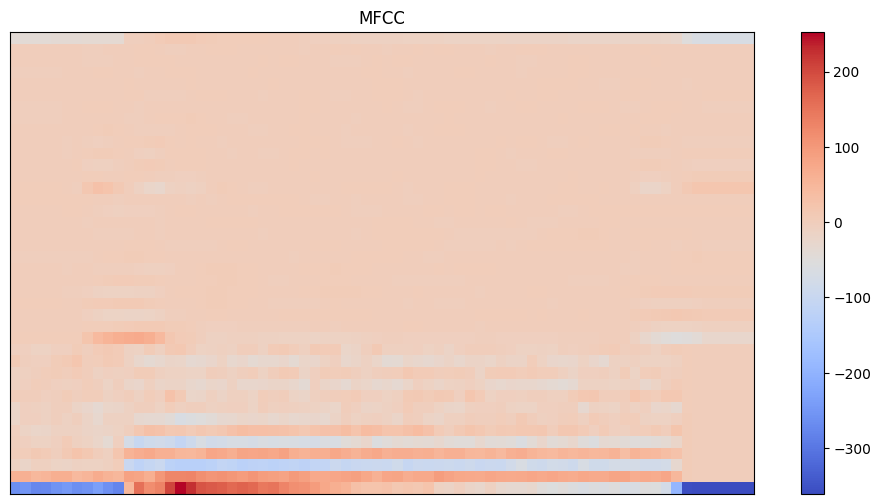

图像已保存到 D:\jupyter notebook\Transfer_learning_to_DiTingV2\dataset\output MFCC 目录。


In [19]:
#MFCC转换
import numpy as np
import torch
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
from torchvision import transforms

# 定义 MFCC 函数
def MFCC(data, sample_rate=50, n_mfcc=13, n_fft=142, hop_length=42):
    data = np.array(data, dtype=np.float32)
    num_samples, num_features, num_time_steps = data.shape
    mfcc_data = np.zeros((num_samples, num_features, 40, 72), dtype=np.float32)
    
    for i in range(num_samples):
        for k in range(num_features):
            # 计算MFCC
            mfcc = librosa.feature.mfcc(y=data[i][k], sr=sample_rate, n_mfcc=n_mfcc, win_length=n_fft, hop_length=hop_length, n_fft=n_fft)
            # 一阶差分
            delta_mfcc = librosa.feature.delta(data=mfcc)
            # 二阶差分
            delta2_mfcc = librosa.feature.delta(data=mfcc, order=2)
            # 计算音频信号每帧的对数能量
            log_energy = librosa.amplitude_to_db(librosa.feature.rms(y=data[i][k], frame_length=n_fft, hop_length=hop_length))
    
            mfcc = np.concatenate([mfcc, delta_mfcc, delta2_mfcc, log_energy], axis=0)
            mfcc_data[i][k] = mfcc
            
    return mfcc_data

# 定义保存 MFCC 数据的函数
def mfcc_tensor_save(data):
    MFCC_data = []
    for i in range(data.shape[0]):
        mfcc_data = data[i:i+1,:,:]
        mfcc_images = MFCC(mfcc_data)
        MFCC_data.append(mfcc_images)
    MFCC_data = torch.tensor(MFCC_data).squeeze(dim=1)
    return MFCC_data

base_path = "D:\\jupyter notebook\\Transfer_learning_to_DiTingV2"
data = torch.load(base_path+'\\tensor dataset\\natural_test_dataset.pt')
print(data.shape)
STFT_data=[]
for i in range(data.shape[0]):
    stft_data=data[i:i+1,:,:]
    stft_images = MFCC(stft_data)
    STFT_data.append(stft_images)
STFT_data=torch.tensor(STFT_data).squeeze(dim=1)
print(STFT_data.shape)

loaded_natural_train = torch.load(base_path+'\\tensor dataset\\natural_train_dataset.pt')
natural_train_MFCC=mfcc_tensor_save(loaded_natural_train)
torch.save(natural_train_MFCC, base_path+'\\tensor dataset MFCC\\natural_train_MFCC.pt')
del loaded_natural_train,natural_train_MFCC
loaded_natural_test = torch.load(base_path+'\\tensor dataset\\natural_test_dataset.pt')
natural_test_MFCC=mfcc_tensor_save(loaded_natural_test)
torch.save(natural_test_MFCC, base_path+'\\tensor dataset MFCC\\natural_test_MFCC.pt')
del loaded_natural_test,natural_test_MFCC
loaded_ep_train = torch.load(base_path+'\\tensor dataset\\ep_train_dataset.pt')
ep_train_MFCC=mfcc_tensor_save(loaded_ep_train)
torch.save(ep_train_MFCC, base_path+'\\tensor dataset MFCC\\ep_train_MFCC.pt')
del loaded_ep_train,ep_train_MFCC
loaded_ep_test = torch.load(base_path+'\\tensor dataset\\ep_test_dataset.pt')
ep_test_MFCC=mfcc_tensor_save(loaded_ep_test)
torch.save(ep_test_MFCC, base_path+'\\tensor dataset MFCC\\ep_test_MFCC.pt')
del loaded_ep_test,ep_test_MFCC
loaded_ss_train = torch.load(base_path+'\\tensor dataset\\ss_train_dataset.pt')
ss_train_MFCC=mfcc_tensor_save(loaded_ss_train)
torch.save(ss_train_MFCC, base_path+'\\tensor dataset MFCC\\ss_train_MFCC.pt')
del loaded_ss_train,ss_train_MFCC
loaded_ss_test = torch.load(base_path+'\\tensor dataset\\ss_test_dataset.pt')
ss_test_MFCC=mfcc_tensor_save(loaded_ss_test)
torch.save(ss_test_MFCC, base_path+'\\tensor dataset MFCC\\ss_test_MFCC.pt')
del loaded_ss_test,ss_test_MFCC



torch.Size([1774, 3, 40, 72])


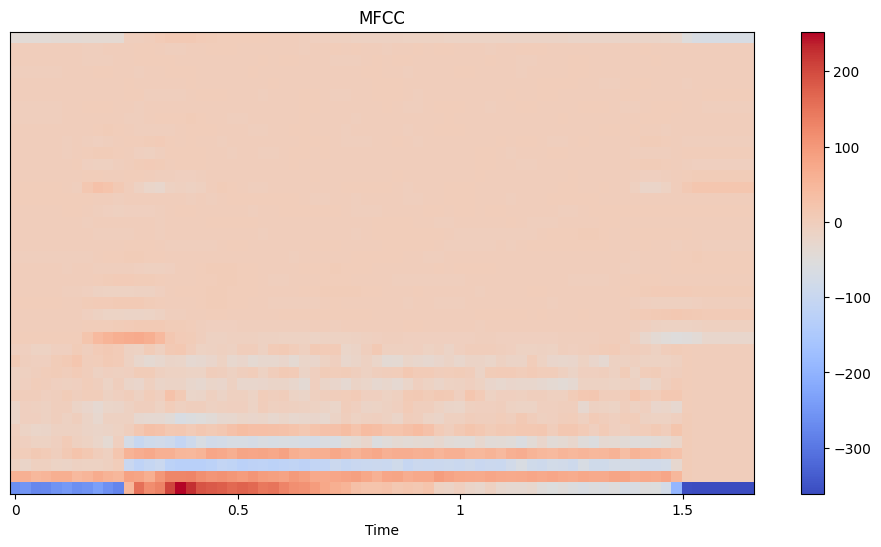

Saving image 1_1: max=165.26954650878906, min=-164.6698760986328
Saving image 1_2: max=170.28094482421875, min=-158.78421020507812
Saving image 1_3: max=169.7368621826172, min=-176.59957885742188
Saving image 2_1: max=201.26255798339844, min=-173.49574279785156
Saving image 2_2: max=186.99794006347656, min=-178.7347412109375
Saving image 2_3: max=201.29202270507812, min=-213.25807189941406
Saving image 3_1: max=208.34963989257812, min=-140.83111572265625
Saving image 3_2: max=207.45489501953125, min=-126.16028594970703
Saving image 3_3: max=211.28123474121094, min=-124.20671081542969
Saving image 4_1: max=179.7337646484375, min=-357.21124267578125
Saving image 4_2: max=215.69570922851562, min=-384.5448913574219
Saving image 4_3: max=206.36138916015625, min=-382.59228515625
Saving image 5_1: max=212.77035522460938, min=-144.22402954101562
Saving image 5_2: max=203.4412841796875, min=-129.1043701171875
Saving image 5_3: max=198.25714111328125, min=-125.05427551269531
Saving image 6_1: ma

In [3]:
base_path = "D:\\jupyter notebook\\Transfer_learning_to_DiTingV2"

import numpy as np
import torch
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
from torchvision import transforms

# 将MFCC数据可视化
sample_index = 35  # 选择一个样本进行展示
# 载入保存的MFCC数据
MFCC_data = torch.load(base_path+'\\tensor dataset MFCC\\natural_test_MFCC.pt')
print(MFCC_data.shape)

plt.figure(figsize=(12, 6))
plt.title('MFCC')
# 将 PyTorch 张量转换为 NumPy 数组
mfcc_numpy = MFCC_data[sample_index][0].numpy()
librosa.display.specshow(mfcc_numpy, x_axis='time')
plt.colorbar()
plt.show()

# 保存 MFCC 数据为图像
save_tensor = MFCC_data.numpy()  # 需要转换为 NumPy 数组
save_dir = 'D:\\jupyter notebook\\Transfer_learning_to_DiTingV2\\dataset\\output MFCC'

os.makedirs(save_dir, exist_ok=True)

num_images_to_save = 60
saved_image_count = 0

for i in range(save_tensor.shape[0]):
    if saved_image_count >= num_images_to_save:
        break
    for j in range(save_tensor.shape[1]):
        if saved_image_count >= num_images_to_save:
            break
        image_tensor = save_tensor[i][j]

        # 调试信息，检查每个图像的最大值和最小值
        print(f"Saving image {i + 1}_{j + 1}: max={image_tensor.max()}, min={image_tensor.min()}")

        # 使用 matplotlib 保存图像
        plt.figure(figsize=(12, 6))
        librosa.display.specshow(image_tensor, x_axis='time')
        plt.colorbar()
        filename = os.path.join(save_dir, f'{i + 1:05d}_{j + 1:02d}.png')
        plt.savefig(filename)
        plt.close()

        saved_image_count += 1

print(f'图像已保存到 {save_dir} 目录，共保存 {saved_image_count} 张图像。')

In [5]:
import torch
import os

# 设置数据路径
data_dir = 'D:\\jupyter notebook\\Transfer_learning_to_DiTingV2\\tensor dataset MFCC'

# 列出所有.pt文件
data_files = [f for f in os.listdir(data_dir) if f.endswith('.pt')]
data_files.sort()  # 确保文件顺序一致

# 打印每个文件的形状和基本信息
for file_name in data_files:
    file_path = os.path.join(data_dir, file_name)
    data = torch.load(file_path)
    print(f"File: {file_name}")
    print(f"Shape: {data.shape}")
    print(f"Data type: {data.dtype}")
    print(f"Max value: {data.max()}")
    print(f"Min value: {data.min()}")
    print(f"Mean value: {data.mean()}")
    print('-' * 40)

File: ep_test_MFCC.pt
Shape: torch.Size([1165, 3, 40, 72])
Data type: torch.float32
Max value: 296.8826599121094
Min value: -497.0565185546875
Mean value: -0.09375729411840439
----------------------------------------
File: ep_train_MFCC.pt
Shape: torch.Size([4358, 3, 40, 72])
Data type: torch.float32
Max value: 294.2976379394531
Min value: -486.6182861328125
Mean value: -0.17829309403896332
----------------------------------------
File: natural_test_MFCC.pt
Shape: torch.Size([1774, 3, 40, 72])
Data type: torch.float32
Max value: 315.1269226074219
Min value: -1131.370849609375
Mean value: -0.7138584852218628
----------------------------------------
File: natural_train_MFCC.pt
Shape: torch.Size([7038, 3, 40, 72])
Data type: torch.float32
Max value: 325.9421691894531
Min value: -1131.370849609375
Mean value: -0.7376800775527954
----------------------------------------
File: ss_test_MFCC.pt
Shape: torch.Size([1067, 3, 40, 72])
Data type: torch.float32
Max value: 287.5705871582031
Min value

In [1]:
import torch
import os
from sklearn.model_selection import train_test_split

# 设置数据路径
data_dir = 'D:\\jupyter notebook\\Transfer_learning_to_DiTingV2\\tensor dataset MFCC'

# 类别及对应文件名
categories = {
    'natural': ['natural_train_MFCC.pt', 'natural_test_MFCC.pt'],
    'ep': ['ep_train_MFCC.pt', 'ep_test_MFCC.pt'],
    'ss': ['ss_train_MFCC.pt', 'ss_test_MFCC.pt']
}

# 加载数据并合并
train_data_list = []
train_labels_list = []
test_data_list = []
test_labels_list = []

label_to_idx = {label: idx for idx, label in enumerate(categories.keys())}

for label, files in categories.items():
    train_file, test_file = files
    # 加载训练数据
    train_path = os.path.join(data_dir, train_file)
    train_data = torch.load(train_path)
    train_data_list.append(train_data)
    train_labels_list.extend([label_to_idx[label]] * len(train_data))
    
    # 加载测试数据
    test_path = os.path.join(data_dir, test_file)
    test_data = torch.load(test_path)
    test_data_list.append(test_data)
    test_labels_list.extend([label_to_idx[label]] * len(test_data))

# 将训练数据和标签合并
train_data = torch.cat(train_data_list, dim=0)
train_labels = torch.tensor(train_labels_list, dtype=torch.long)

# 将测试数据和标签合并
test_data = torch.cat(test_data_list, dim=0)
test_labels = torch.tensor(test_labels_list, dtype=torch.long)

print(f"Total train data shape: {train_data.shape}")
print(f"Total train labels shape: {train_labels.shape}")
print(f"Total test data shape: {test_data.shape}")
print(f"Total test labels shape: {test_labels.shape}")

# 按4:1比例划分训练集和验证集
train_data, val_data, train_labels, val_labels = train_test_split(
    train_data, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

print(f"Train data shape: {train_data.shape}, Train labels shape: {train_labels.shape}")
print(f"Validation data shape: {val_data.shape}, Validation labels shape: {val_labels.shape}")
print(f"Test data shape: {test_data.shape}, Test labels shape: {test_labels.shape}")

# 保存划分后的数据集
output_dir = 'D:\\jupyter notebook\\Transfer_learning_to_DiTingV2\\tensor dataset MFCC\\split'
os.makedirs(output_dir, exist_ok=True)

torch.save((train_data, train_labels), os.path.join(output_dir, 'train_MFCC.pt'))
torch.save((val_data, val_labels), os.path.join(output_dir, 'val_MFCC.pt'))
torch.save((test_data, test_labels), os.path.join(output_dir, 'test_MFCC.pt'))

print(f"Data saved to {output_dir}")

C:\Users\25642\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Total train data shape: torch.Size([15573, 3, 40, 72])
Total train labels shape: torch.Size([15573])
Total test data shape: torch.Size([4006, 3, 40, 72])
Total test labels shape: torch.Size([4006])
Train data shape: torch.Size([12458, 3, 40, 72]), Train labels shape: torch.Size([12458])
Validation data shape: torch.Size([3115, 3, 40, 72]), Validation labels shape: torch.Size([3115])
Test data shape: torch.Size([4006, 3, 40, 72]), Test labels shape: torch.Size([4006])
Data saved to D:\jupyter notebook\Transfer_learning_to_DiTingV2\tensor dataset MFCC\split


In [9]:
import torch
import os

# 设置数据路径
split_data_dir = 'D:\\jupyter notebook\\Transfer_learning_to_DiTingV2\\tensor dataset MFCC\\split'

# 文件列表
data_files = ['train_MFCC.pt', 'val_MFCC.pt', 'test_MFCC.pt']

# 打印每个文件的形状和基本信息
for file_name in data_files:
    file_path = os.path.join(split_data_dir, file_name)
    data, labels = torch.load(file_path)
    print(f"File: {file_name}")
    print(f"Data shape: {data.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Data type: {data.dtype}")
    print(f"Max value in data: {data.max()}")
    print(f"Min value in data: {data.min()}")
    print(f"Mean value in data: {data.mean()}")
    print(f"Unique labels: {torch.unique(labels)}")
    print('-' * 40)

File: train_MFCC.pt
Data shape: torch.Size([15663, 3, 40, 72])
Labels shape: torch.Size([15663])
Data type: torch.float32
Max value in data: 325.9421691894531
Min value in data: -1131.370849609375
Mean value in data: -0.1272970736026764
Unique labels: tensor([0, 1, 2])
----------------------------------------
File: val_MFCC.pt
Data shape: torch.Size([1958, 3, 40, 72])
Labels shape: torch.Size([1958])
Data type: torch.float32
Max value in data: 316.44500732421875
Min value in data: -1131.370849609375
Mean value in data: -0.12065096199512482
Unique labels: tensor([0, 1, 2])
----------------------------------------
File: test_MFCC.pt
Data shape: torch.Size([1958, 3, 40, 72])
Labels shape: torch.Size([1958])
Data type: torch.float32
Max value in data: 314.93670654296875
Min value in data: -1131.370849609375
Mean value in data: -0.1044086217880249
Unique labels: tensor([0, 1, 2])
----------------------------------------


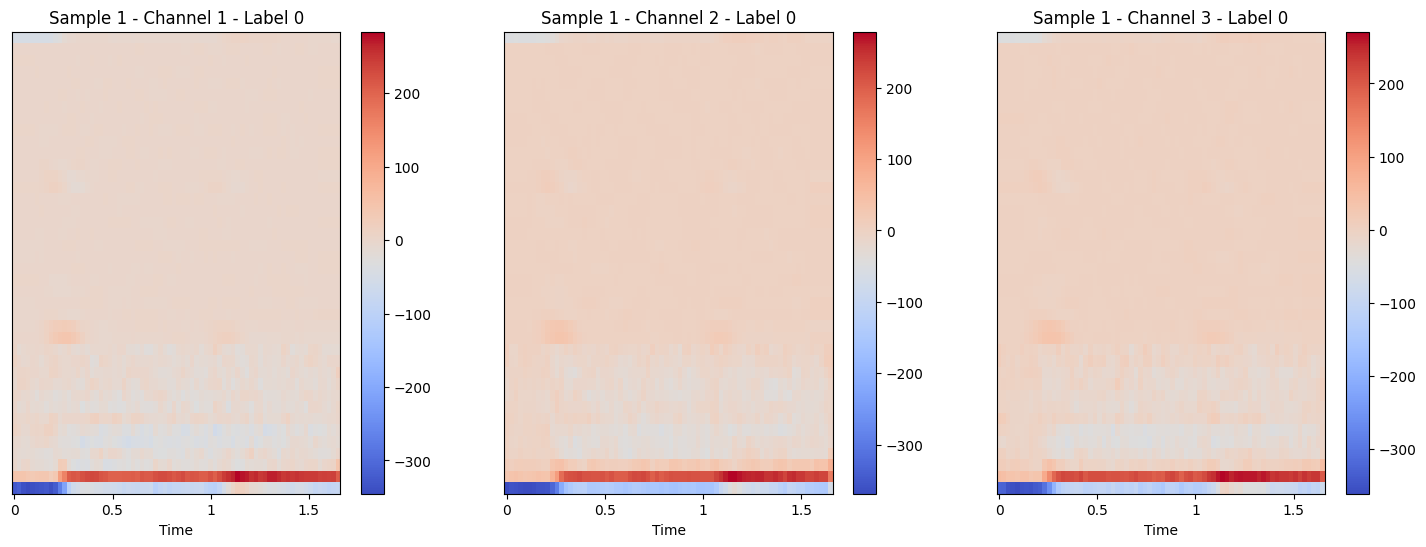

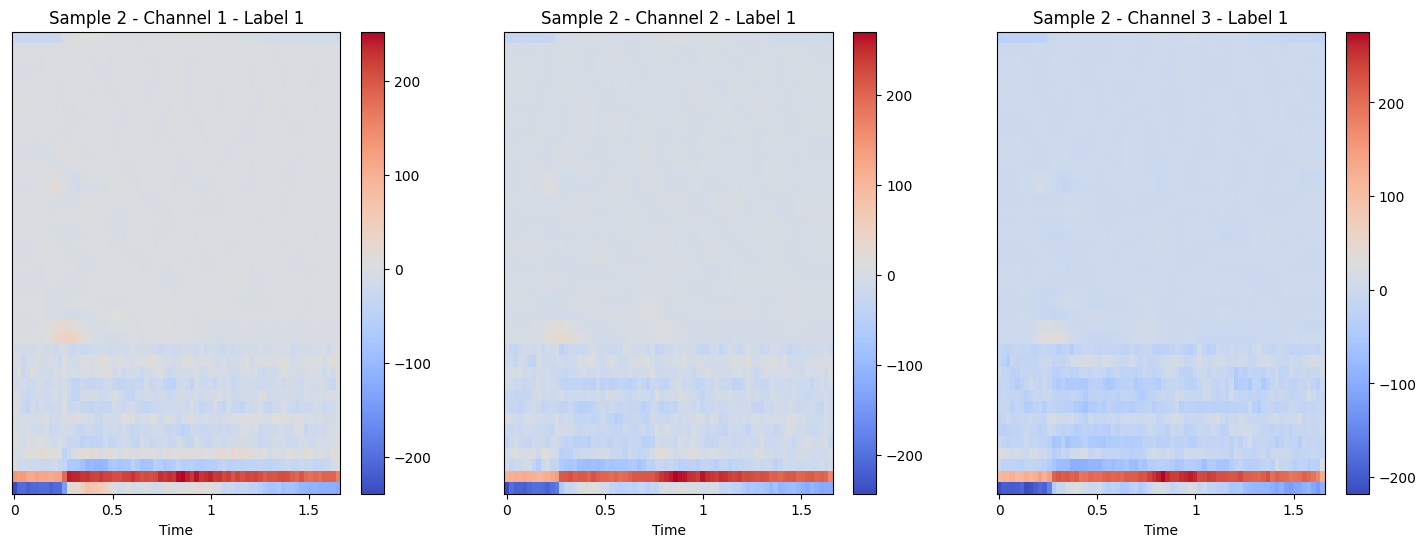

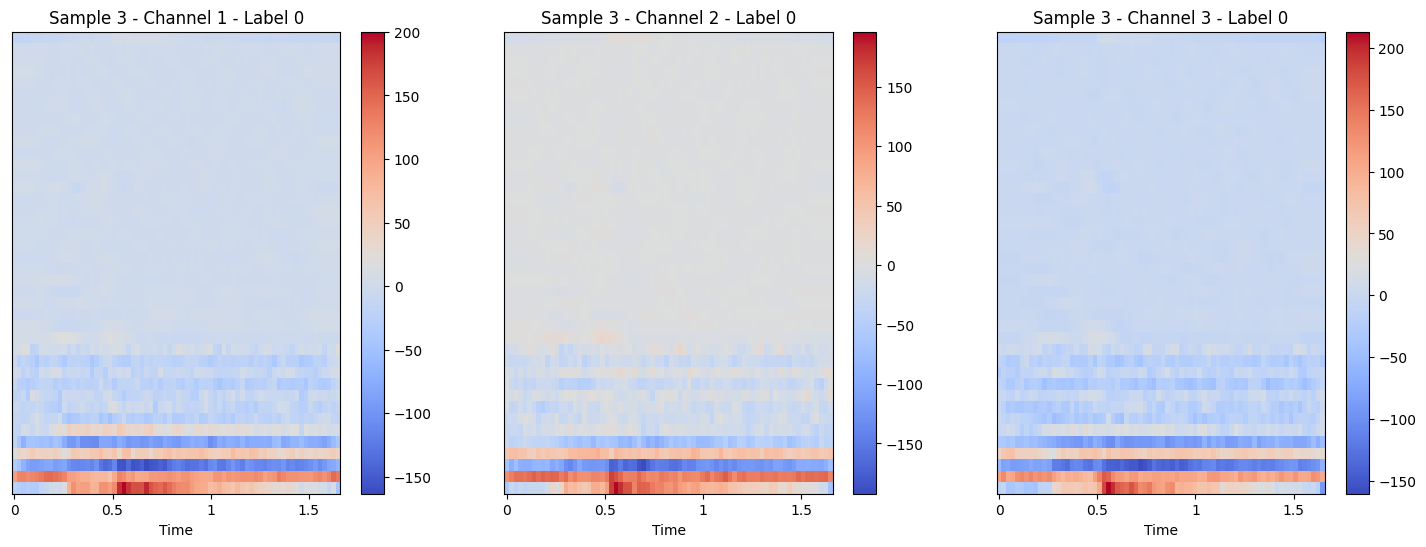

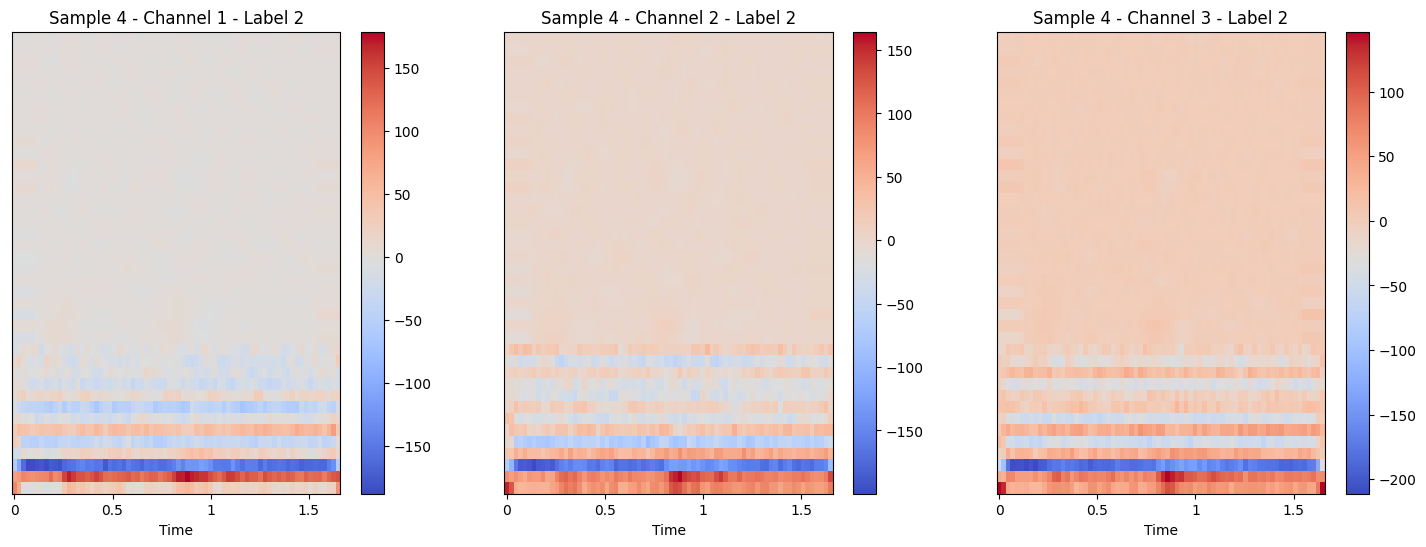

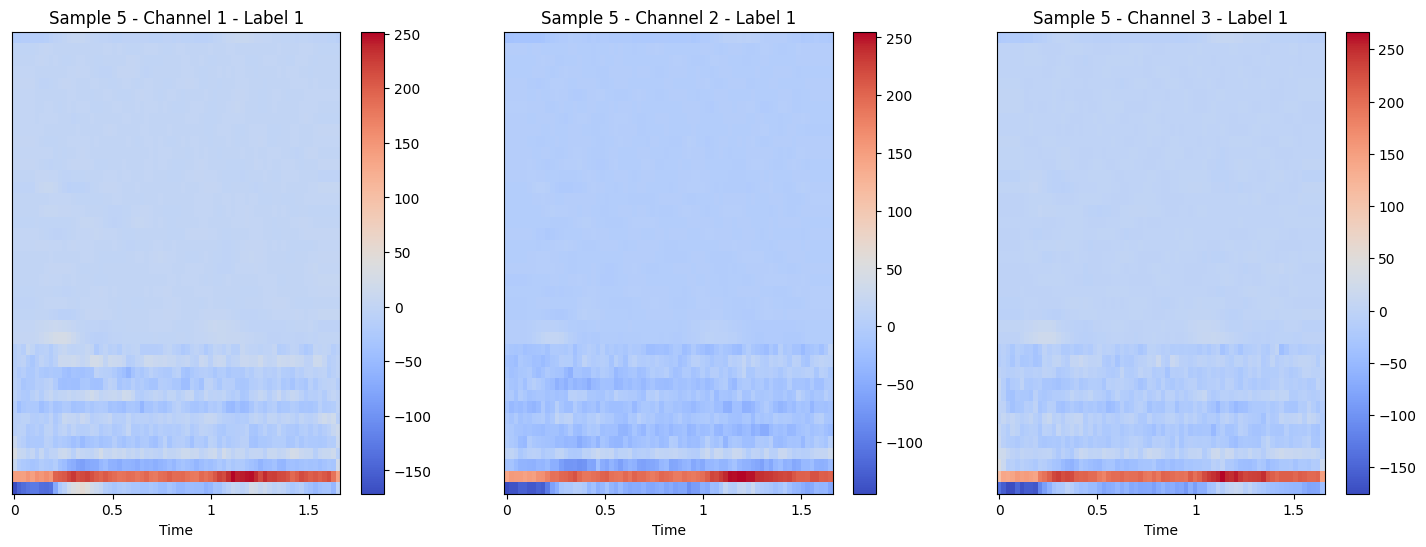

In [11]:
import torch
import matplotlib.pyplot as plt
import librosa.display
import os

# 设置数据路径
split_data_dir = 'D:\\jupyter notebook\\Transfer_learning_to_DiTingV2\\Dataloader_MFCC'
train_data_path = os.path.join(split_data_dir, 'train_MFCC.pt')

# 加载数据
train_data, train_labels = torch.load(train_data_path)

# 可视化一些样本
num_samples_to_visualize = 5
for i in range(num_samples_to_visualize):
    data = train_data[i]
    label = train_labels[i].item()
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    for j in range(3):
        ax = axes[j]
        mfcc = data[j].numpy()
        img = librosa.display.specshow(mfcc, ax=ax, x_axis='time')
        ax.set_title(f'Sample {i+1} - Channel {j+1} - Label {label}')
        fig.colorbar(img, ax=ax)
    plt.show()

In [7]:
import torch
import os
import numpy as np

# 定义路径
base_path = 'D:\\jupyter notebook\\Transfer_learning_to_DiTingV2\\Dataloader_MFCC'
train_path = os.path.join(base_path, 'train_MFCC.pt')
val_path = os.path.join(base_path, 'val_MFCC.pt')
test_path = os.path.join(base_path, 'test_MFCC.pt')

# 加载数据
train_data = torch.load(train_path)
val_data = torch.load(val_path)
test_data = torch.load(test_path)

# 解包数据
train_data, train_labels = train_data
val_data, val_labels = val_data
test_data, test_labels = test_data

# 打印数据集的信息
def print_dataset_info(data, labels, dataset_name):
    unique, counts = np.unique(labels.numpy(), return_counts=True)
    label_distribution = dict(zip(unique, counts))

    print(f'{dataset_name} 数据集信息:')
    print(f'数据形状: {data.shape}')
    print(f'标签形状: {labels.shape}')
    print(f'样本数量: {len(data)}')
    print(f'样本的形状: {data[0].shape}')
    print(f'样本的类型: {type(data[0])}')
    print(f'标签分布: {label_distribution}')
    print('-' * 30)

# 打印训练集、验证集和测试集的信息
print_dataset_info(train_data, train_labels, '训练集')
print_dataset_info(val_data, val_labels, '验证集')
print_dataset_info(test_data, test_labels, '测试集')

训练集 数据集信息:
数据形状: torch.Size([12458, 3, 40, 72])
标签形状: torch.Size([12458])
样本数量: 12458
样本的形状: torch.Size([3, 40, 72])
样本的类型: <class 'torch.Tensor'>
标签分布: {0: 5630, 1: 3486, 2: 3342}
------------------------------
验证集 数据集信息:
数据形状: torch.Size([3115, 3, 40, 72])
标签形状: torch.Size([3115])
样本数量: 3115
样本的形状: torch.Size([3, 40, 72])
样本的类型: <class 'torch.Tensor'>
标签分布: {0: 1408, 1: 872, 2: 835}
------------------------------
测试集 数据集信息:
数据形状: torch.Size([4006, 3, 40, 72])
标签形状: torch.Size([4006])
样本数量: 4006
样本的形状: torch.Size([3, 40, 72])
样本的类型: <class 'torch.Tensor'>
标签分布: {0: 1774, 1: 1165, 2: 1067}
------------------------------


C:\Users\25642\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\jupyter notebook\\Transfer_learning_to_DiTingV2\\dataset\\output svg/natural_train\\natural_image_0.svg'

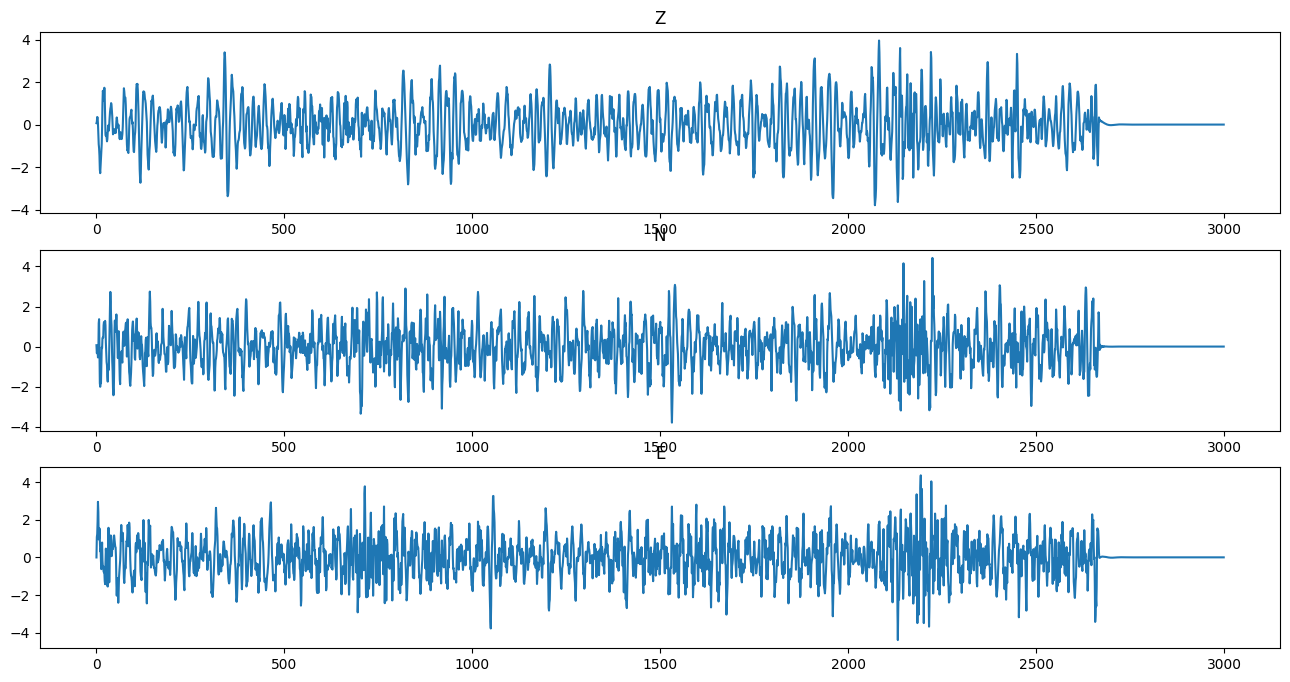

In [1]:
#矢量图（地震波形图）
import os
import random
import torch
import matplotlib.pyplot as plt

# 加载数据
base_path = 'D:/jupyter notebook/Transfer_learning_to_DiTingV2/tensor dataset'
natural_train_dataset = torch.load(os.path.join(base_path, 'natural_train_dataset.pt'))
ep_train_dataset = torch.load(os.path.join(base_path, 'ep_train_dataset.pt'))
ss_train_dataset = torch.load(os.path.join(base_path, 'ss_train_dataset.pt'))

output_base_path = 'D:/jupyter notebook/Transfer_learning_to_DiTingV2/dataset/output_svg'

# 创建输出目录
os.makedirs(os.path.join(output_base_path, 'natural_train'), exist_ok=True)
os.makedirs(os.path.join(output_base_path, 'ep_train'), exist_ok=True)
os.makedirs(os.path.join(output_base_path, 'ss_train'), exist_ok=True)

# 自然地震数据集
for i in range(50):
    selected_sample = random.randint(0, natural_train_dataset.size(0) - 1)
    fig, ax = plt.subplots(3, 1, figsize=(16, 8))

    ax[0].plot(natural_train_dataset[selected_sample, 0, :].numpy())
    ax[1].plot(natural_train_dataset[selected_sample, 1, :].numpy())
    ax[2].plot(natural_train_dataset[selected_sample, 2, :].numpy())
    ax[0].set_title('Z')
    ax[1].set_title('N')
    ax[2].set_title('E')

    # 保存图像为SVG
    output_path = os.path.join(output_base_path, 'natural_train', f'natural_image_{i}.svg')
    plt.savefig(output_path, format='svg')
    plt.close(fig)

# 爆破数据集
for i in range(50):
    selected_sample = random.randint(0, ep_train_dataset.size(0) - 1)
    fig, ax = plt.subplots(3, 1, figsize=(16, 8))

    ax[0].plot(ep_train_dataset[selected_sample, 0, :].numpy())
    ax[1].plot(ep_train_dataset[selected_sample, 1, :].numpy())
    ax[2].plot(ep_train_dataset[selected_sample, 2, :].numpy())
    ax[0].set_title('Z')
    ax[1].set_title('N')
    ax[2].set_title('E')

    # 保存图像为SVG
    output_path = os.path.join(output_base_path, 'ep_train', f'ep_image_{i}.svg')
    plt.savefig(output_path, format='svg')
    plt.close(fig)

# 塌陷数据集
for i in range(50):
    selected_sample = random.randint(0, ss_train_dataset.size(0) - 1)
    fig, ax = plt.subplots(3, 1, figsize=(16, 8))

    ax[0].plot(ss_train_dataset[selected_sample, 0, :].numpy())
    ax[1].plot(ss_train_dataset[selected_sample, 1, :].numpy())
    ax[2].plot(ss_train_dataset[selected_sample, 2, :].numpy())
    ax[0].set_title('Z')
    ax[1].set_title('N')
    ax[2].set_title('E')

    # 保存图像为SVG
    output_path = os.path.join(output_base_path, 'ss_train', f'ss_image_{i}.svg')
    plt.savefig(output_path, format='svg')
    plt.close(fig)

In [3]:
#矢量图（时频图）
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import random

# 基础路径和频谱图文件夹路径
base_path = 'D:/jupyter notebook/Transfer_learning_to_DiTingV2'
stft_folder_path = os.path.join(base_path, 'tensor dataset stft')
output_stft_svg_folder = os.path.join(base_path, 'dataset', 'output_stft_svg')  # 目标输出路径

# 函数：绘制和保存频谱图
def plot_and_save_spectrogram(dataset_path, dataset_type):
    # 创建对应数据集的输出文件夹
    dataset_output_folder = os.path.join(output_stft_svg_folder, dataset_type)
    os.makedirs(dataset_output_folder, exist_ok=True)

    # 加载频谱图数据
    dataset = torch.load(dataset_path)

    # 随机选择并绘制50个样本的频谱图
    for i in range(50):
        selected_sample = random.randint(0, dataset.size(0) - 1)
        fig, ax = plt.subplots(3, 1, figsize=(16, 8))

        # 绘制每个通道
        for j in range(3):
            # 取对数以改善视觉效果
            spectrogram = 20 * np.log10(dataset[selected_sample, j] + 1e-6)  # 加小量避免log(0)
            img = ax[j].imshow(spectrogram, aspect='auto', origin='lower')
            ax[j].set_title(['Z', 'N', 'E'][j] + ' Channel')
            fig.colorbar(img, ax=ax[j])

        # 保存图像为SVG
        output_path = os.path.join(dataset_output_folder, f'{dataset_type}_image_{i}.svg')
        plt.savefig(output_path, format='svg')
        plt.close(fig)

# 示例调用
plot_and_save_spectrogram(os.path.join(stft_folder_path, 'natural_train_dataset_stft.pt'), 'natural_train')
plot_and_save_spectrogram(os.path.join(stft_folder_path, 'ep_train_dataset_stft.pt'), 'ep_train')
plot_and_save_spectrogram(os.path.join(stft_folder_path, 'ss_train_dataset_stft.pt'), 'ss_train')

In [5]:
#矢量图（MFCC)
import numpy as np
import torch
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os

# 基础路径设置
base_path = "D:\\jupyter notebook\\Transfer_learning_to_DiTingV2"
mfcc_folder_path = os.path.join(base_path, 'tensor dataset MFCC')
output_mfcc_svg_folder = os.path.join(base_path, 'dataset', 'output_MFCC_svg')  # 目标输出路径

# 创建输出目录
os.makedirs(output_mfcc_svg_folder, exist_ok=True)

# 载入MFCC数据
MFCC_data = torch.load(os.path.join(mfcc_folder_path, 'natural_test_MFCC.pt'))
print(MFCC_data.shape)

# 将 MFCC 数据保存为 SVG 图像
num_images_to_save = 60
saved_image_count = 0

for i in range(MFCC_data.shape[0]):
    if saved_image_count >= num_images_to_save:
        break
    for j in range(MFCC_data.shape[1]):
        if saved_image_count >= num_images_to_save:
            break
        image_tensor = MFCC_data[i][j].numpy()

        # 调试信息，检查每个图像的最大值和最小值
        print(f"Saving image {i + 1}_{j + 1}: max={image_tensor.max()}, min={image_tensor.min()}")

        # 使用 matplotlib 保存图像
        plt.figure(figsize=(12, 6))
        librosa.display.specshow(image_tensor, x_axis='time')
        plt.colorbar()
        filename = os.path.join(output_mfcc_svg_folder, f'{i + 1:05d}_{j + 1:02d}.svg')
        plt.savefig(filename, format='svg')
        plt.close()

        saved_image_count += 1

print(f'图像已保存到 {output_mfcc_svg_folder} 目录，共保存 {saved_image_count} 张图像。')

torch.Size([1774, 3, 40, 72])
Saving image 1_1: max=165.26954650878906, min=-164.6698760986328
Saving image 1_2: max=170.28094482421875, min=-158.78421020507812
Saving image 1_3: max=169.7368621826172, min=-176.59957885742188
Saving image 2_1: max=201.26255798339844, min=-173.49574279785156
Saving image 2_2: max=186.99794006347656, min=-178.7347412109375
Saving image 2_3: max=201.29202270507812, min=-213.25807189941406
Saving image 3_1: max=208.34963989257812, min=-140.83111572265625
Saving image 3_2: max=207.45489501953125, min=-126.16028594970703
Saving image 3_3: max=211.28123474121094, min=-124.20671081542969
Saving image 4_1: max=179.7337646484375, min=-357.21124267578125
Saving image 4_2: max=215.69570922851562, min=-384.5448913574219
Saving image 4_3: max=206.36138916015625, min=-382.59228515625
Saving image 5_1: max=212.77035522460938, min=-144.22402954101562
Saving image 5_2: max=203.4412841796875, min=-129.1043701171875
Saving image 5_3: max=198.25714111328125, min=-125.05427